<a href="https://colab.research.google.com/github/A-H-Sumon/FusionNet/blob/main/NumtaDbFusionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from joblib import Parallel, delayed
import multiprocessing

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage.filters import gabor
from joblib import Parallel, delayed
import multiprocessing
from termcolor import colored

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d BengaliAI/numta --unzip


Dataset URL: https://www.kaggle.com/datasets/BengaliAI/numta
License(s): CC-BY-SA-4.0
 97% 1.85G/1.91G [00:21<00:01, 37.3MB/s]
100% 1.91G/1.91G [00:21<00:00, 96.4MB/s]


In [ ]:
# ======================== Data Loading ========================
base_path = "/content"



# Load and combine all labeled training data
all_image_paths = []
all_labels = []

for file_name in os.listdir(base_path):
    if file_name.startswith("training-") and file_name.endswith(".csv"):
        train_file_path = os.path.join(base_path, file_name)
        labels_df = pd.read_csv(train_file_path)
        folder_name = file_name.replace(".csv", "")
        folder_path = os.path.join(base_path, folder_name)

        if os.path.exists(folder_path):
            for _, row in labels_df.iterrows():
                image_file = row['filename']
                label = row['digit']
                image_path = os.path.join(folder_path, image_file)
                all_image_paths.append(image_path)
                all_labels.append(label)

# ===================== Train/Test Split =====================
X_train, X_test, y_train, y_test = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# ===================== Create DataFrames =====================
train_df = pd.DataFrame({"image_path": X_train, "label": y_train})
test_df = pd.DataFrame({"image_path": X_test, "label": y_test})



In [ ]:
print(train_df['label'].unique())  # Check unique labels in the dataset
print(train_df['label'].nunique())  # Check the number of unique classes


[8 9 5 7 6 0 3 1 2 4]
10


In [ ]:
print(f"Total training images: {len(train_df)}")
print(f"Total testing images: {len(test_df)}")

Total training images: 57636
Total testing images: 14409


In [ ]:
import cv2
import numpy as np
import cv2.ximgproc as xip

def preprocess_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros((28, 28))  # Placeholder for missing images

    # Apply Otsu's Thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize image to 28x28
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA) / 255.0

    return img


In [ ]:
# ======================== Load & Preprocess Images ========================
train_images = np.array([preprocess_image(fp) for fp in train_df['image_path'].values])


In [ ]:
import cv2
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random



def augment_image(img):
    rows, cols = img.shape

    # Random Rotation
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))

    # Random Shifting
    tx = random.uniform(-2, 2)
    ty = random.uniform(-2, 2)
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(rotated, M_shift, (cols, rows))

    return shifted

def augment_dataset(train_images):
    """Applies augmentation to a dataset using parallel processing."""
    num_cores = multiprocessing.cpu_count()
    augmented_images = Parallel(n_jobs=num_cores)(
        delayed(augment_image)(img) for img in train_images
    )
    return np.array(augmented_images)

# Apply augmentation to dataset
augmented_images = augment_dataset(train_images)




In [ ]:
cores = multiprocessing.cpu_count()
print(cores)

2


In [ ]:


!pip install mahotas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.5 MB/s eta 0:00:00


In [ ]:
from joblib import Parallel, delayed
import numpy as np
import multiprocessing
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from mahotas.features import zernike_moments

# Feature Extraction
def extract_features_single(img):
    # Extract HOG features
    hog_features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True)

    # Extract Gabor features
    gabor_response_real, gabor_response_imag = gabor(img, frequency=0.6)
    gabor_features = np.mean(gabor_response_real) + np.mean(gabor_response_imag)

    # Extract LBP features
    lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize LBP histogram

    return np.hstack([hog_features, gabor_features, lbp_hist])

def extract_features(images):
    num_cores = multiprocessing.cpu_count()
    features = Parallel(n_jobs=num_cores)(delayed(extract_features_single)(img) for img in images)
    return np.array(features)

# Apply feature extraction
augmented_features = extract_features(augmented_images)



In [ ]:
# ======================== Data Preparation ========================
X_train_preprocessed = np.array([preprocess_image(fp) for fp in train_df['image_path']])
X_test_preprocessed = np.array([preprocess_image(fp) for fp in test_df['image_path']])

In [ ]:
# Apply augmentation
X_train_augmented = augment_dataset(X_train_preprocessed)




In [ ]:


from tensorflow.keras import Input, layers, models, Model

def build_feature_extractor():
    inputs = Input(shape=(28, 28, 1))  # Explicit Input layer

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', name='feature_layer')(x)

    return Model(inputs, x, name="feature_extractor")

def train_feature_extractor(X_train, y_train):
    # Build base feature extractor
    base_model = build_feature_extractor()

    # Add classification head
    x = layers.Dense(10, activation='softmax')(base_model.output)
    train_model = Model(inputs=base_model.input, outputs=x)

    train_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

    # Train model
    train_model.fit(X_train, y_train,
                    epochs=10, batch_size=64,
                    validation_split=0.2, verbose=1)

    # Return only the feature extractor (without classification layer)
    return base_model

def extract_features_with_custom_cnn(model, X):
    features = model.predict(X, verbose=0)
    return features
# Ensure data is shaped (N, 28, 28, 1)
X_train_cnn = X_train_preprocessed[..., np.newaxis]
X_test_cnn = X_test_preprocessed[..., np.newaxis]

# Train CNN feature extractor
feature_extractor = train_feature_extractor(X_train_cnn, np.array(train_df['label']))

# Extract features
X_train_features = extract_features_with_custom_cnn(feature_extractor, X_train_cnn)
X_test_features = extract_features_with_custom_cnn(feature_extractor, X_test_cnn)


Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.5515 - loss: 1.3235 - val_accuracy: 0.8926 - val_loss: 0.3555
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9067 - loss: 0.3036 - val_accuracy: 0.9328 - val_loss: 0.2311
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.9426 - loss: 0.1858 - val_accuracy: 0.9433 - val_loss: 0.1857
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.9591 - loss: 0.1344 - val_accuracy: 0.9532 - val_loss: 0.1553
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9707 - loss: 0.0967 - val_accuracy: 0.9568 - val_loss: 0.1427
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9762 - loss: 0.0772 - val_accuracy: 0.9572 - val_loss: 0.1461
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9799 - loss: 0.0614 - val_accuracy: 0.9601 - val_loss: 0.1438
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.9862 - loss: 0.0440 - 

In [ ]:
X_test_features = extract_features_with_custom_cnn(feature_extractor, X_test_cnn)

In [ ]:
# Extract features from augmented images
#X_train_features = extract_features(X_train_augmented)
X_test_features = extract_features_with_trained_cnn(X_test_preprocessed)  # No augmentation for test set

NameError: name 'extract_features_with_trained_cnn' is not defined

In [ ]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df['label'])
y_test = encoder.fit_transform(test_df['label'])

In [ ]:
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.2 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from glob import glob

def load_images(image_paths):
    data = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (64, 64))  # Resize to a fixed size
        img = img.flatten()  # Convert to 1D array
        data.append(img)
    return np.array(data)

# Assuming X_train originally contains image file paths
X_train = load_images(X_train)


In [ ]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.utils import resample
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# ======= Step 1: Sample a Subset of the Training Data =======
X_sampled, y_sampled = resample(
    X_train_features, y_train, n_samples=10000, stratify=y_train, random_state=42
)
# ======= Step 2: Define the Objective Function =======
def objective(trial):
    k = trial.suggest_int('n_neighbors', 3, 15)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)

    # Use cv=3 for faster tuning
    score = cross_val_score(model, X_sampled, y_sampled, cv=3, scoring='accuracy').mean()
    return score

In [ ]:
# ======= Step 3: Create Study with Sampler and Pruner =======
study_knn = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

# ======= Step 4: Optimize with Parallel Processing =======
study_knn.optimize(objective, n_trials=50, n_jobs=2)  # Use 2 cores (Colab-safe)

# ======= Step 5: Retrieve Best Parameters =======
best_knn_params = study_knn.best_params
print("Best KNN hyperparameters:", best_knn_params)






[I 2025-07-31 11:04:29,721] A new study created in memory with name: no-name-03f44524-2bd1-49c4-9d10-aa08c5b5ee5a
[I 2025-07-31 11:04:31,364] Trial 1 finished with value: 0.9470998989521028 and parameters: {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 1 with value: 0.9470998989521028.
[I 2025-07-31 11:04:31,456] Trial 0 finished with value: 0.9486997889950962 and parameters: {'n_neighbors': 9, 'metric': 'minkowski', 'weights': 'uniform'}. Best is trial 0 with value: 0.9486997889950962.
[I 2025-07-31 11:04:48,921] Trial 2 finished with value: 0.9535995891130805 and parameters: {'n_neighbors': 11, 'metric': 'manhattan', 'weights': 'uniform'}. Best is trial 2 with value: 0.9535995891130805.
[I 2025-07-31 11:04:49,125] Trial 3 finished with value: 0.9589999191880795 and parameters: {'n_neighbors': 9, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 3 with value: 0.9589999191880795.
[I 2025-07-31 11:04:50,540] Trial 4 finished with value: 0.94679

Best KNN hyperparameters: {'n_neighbors': 11, 'metric': 'manhattan', 'weights': 'distance'}


In [ ]:
# Extract best values
best_k = best_knn_params['n_neighbors']
best_metric = best_knn_params['metric']
best_weights = best_knn_params['weights']

def knn(X_train, y_train, X_test, k=best_k, metric=best_metric, weights=best_weights):
    """Optimized KNN model."""

    # Convert labels to NumPy array (avoid indexing issues)
    y_train = np.array(y_train)

    # Fit KNN classifier with optimized parameters
    knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn_model.fit(X_train, y_train)

    # Predict on test set
    predictions = knn_model.predict(X_test)

    return predictions


In [ ]:


# Run KNN with optimized parameters
knn_preds = knn(X_train_features, y_train, X_test_features)


In [ ]:
X_train_combined = np.hstack((X_train_features, y_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_features, knn_preds.reshape(-1, 1)))

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

feature_dim = X_train_combined.shape[1]  # Assuming X_train is your feature matrix


def objective(trial):
    """Objective function for optimizing neural network hyperparameters."""

    # Hyperparameters to optimize
    num_units_1 = trial.suggest_int('num_units_1', 128, 512, step=64)  # First Dense layer
    num_units_2 = trial.suggest_int('num_units_2', 64, 256, step=64)   # Second Dense layer
    num_units_3 = trial.suggest_int('num_units_3', 32, 128, step=32)   # Third Dense layer
    dropout_1 = trial.suggest_float('dropout_1', 0.2, 0.5)  # Dropout after first layer
    dropout_2 = trial.suggest_float('dropout_2', 0.2, 0.5)  # Dropout after second layer
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.001)  # Adam learning rate

    # Build model
    model = Sequential([
        Dense(num_units_1, activation='selu', input_shape=(feature_dim,)),
        BatchNormalization(),
        Dropout(dropout_1),
        Dense(num_units_2, activation='selu'),
        BatchNormalization(),
        Dropout(dropout_2),
        Dense(num_units_3, activation='selu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])

    # Compile model with tuned learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model (Use fewer epochs for tuning)
    history = model.fit(
        X_train_combined, y_train,
        epochs=10,  # Keep epochs low for tuning
        batch_size=64,
        validation_split=0.2,
        verbose=0
    )

    # Return best validation accuracy
    return max(history.history['val_accuracy'])


In [ ]:
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=20)  # Run 20 trials

# Get the best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-07-31 11:13:06,501] A new study created in memory with name: no-name-b8816d71-db98-4eb1-8fab-d61488b4ac64
/tmp/ipython-input-3243621785.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.001)  # Adam learning rate
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-07-31 11:14:27,740] Trial 0 finished with value: 0.9922796487808228 and parameters: {'num_units_1': 384, 'num_units_2': 128, 'num_units_3': 128, 'dropout_1': 0.3679616354593608, 'dropout_2': 0.231103263622172

Best hyperparameters: {'num_units_1': 448, 'num_units_2': 192, 'num_units_3': 96, 'dropout_1': 0.20620684548655685, 'dropout_2': 0.26974363235620696, 'learning_rate': 0.0009812196802585188}


In [ ]:
# Unpack Optuna best parameters
num_units_1 = best_params['num_units_1']
num_units_2 = best_params['num_units_2']
num_units_3 = best_params['num_units_3']
dropout_1 = best_params['dropout_1']
dropout_2 = best_params['dropout_2']
learning_rate = best_params['learning_rate']



cv_scores = []
all_preds = []
all_true = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_combined, y_train)):
    print(f"\n===== Training Fold {fold+1} =====")

    X_train_fold, X_val_fold = X_train_combined[train_idx], X_train_combined[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Use tuned architecture
    model = Sequential([
        Dense(num_units_1, activation='selu', input_shape=(X_train_combined.shape[1],)),
        BatchNormalization(), Dropout(dropout_1),

        Dense(num_units_2, activation='selu'),
        BatchNormalization(), Dropout(dropout_2),

        Dense(num_units_3, activation='selu'),
        BatchNormalization(),

        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=20,
              batch_size=64,
              callbacks=[ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)],
              verbose=0)

    val_preds = np.argmax(model.predict(X_val_fold), axis=1)
    val_acc = accuracy_score(y_val_fold, val_preds)
    cv_scores.append(val_acc)

    print(f"Fold {fold+1} Accuracy: {val_acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val_fold)






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



===== Training Fold 1 =====
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 Accuracy: 0.9989

===== Training Fold 2 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 2 Accuracy: 0.9984

===== Training Fold 3 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 Accuracy: 0.9980

===== Training Fold 4 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 4 Accuracy: 0.9990

===== Training Fold 5 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5 Accuracy: 0.9991


In [ ]:
# Summary Metrics
print("\n========== Cross-Validation Summary ==========")
print("Per-fold Accuracies:", [f"{s:.4f}" for s in cv_scores])
print("Mean Accuracy:", f"{np.mean(cv_scores):.4f}")
print("Standard Deviation:", f"{np.std(cv_scores):.4f}")


========== Cross-Validation Summary ==========
Per-fold Accuracies: ['0.9989', '0.9984', '0.9980', '0.9990', '0.9991']
Mean Accuracy: 0.9987
Standard Deviation: 0.0004


In [ ]:
test_preds = np.argmax(model.predict(X_test_combined), axis=1)
accuracy = accuracy_score(y_test, test_preds)
# Print only accuracy
print(f"\n========== Final Accuracy ==========\nAccuracy: {accuracy:.2f}")


print("\n========== Final Classification Report ==========")
print(classification_report(y_test, test_preds, digits=4))


451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

========== Final Accuracy ==========
Accuracy: 0.96

========== Final Classification Report ==========
              precision    recall  f1-score   support

           0     0.9750    0.9696    0.9723      1448
           1     0.9260    0.9562    0.9409      1439
           2     0.9839    0.9730    0.9784      1445
           3     0.9622    0.9509    0.9566      1447
           4     0.9541    0.9738    0.9638      1450
           5     0.9585    0.9565    0.9575      1448
           6     0.9548    0.9521    0.9535      1442
           7     0.9739    0.9875    0.9806      1436
           8     0.9901    0.9832    0.9867      1431
           9     0.9501    0.9241    0.9369      1423

    accuracy                         0.9627     14409
   macro avg     0.9629    0.9627    0.9627     14409
weighted avg     0.9629    0.9627    0.9627     14409



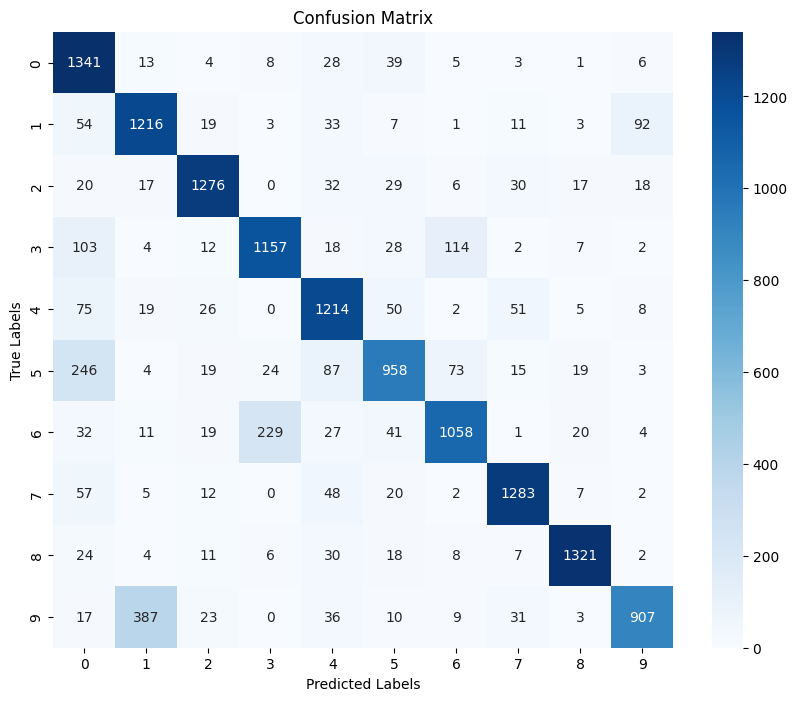

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


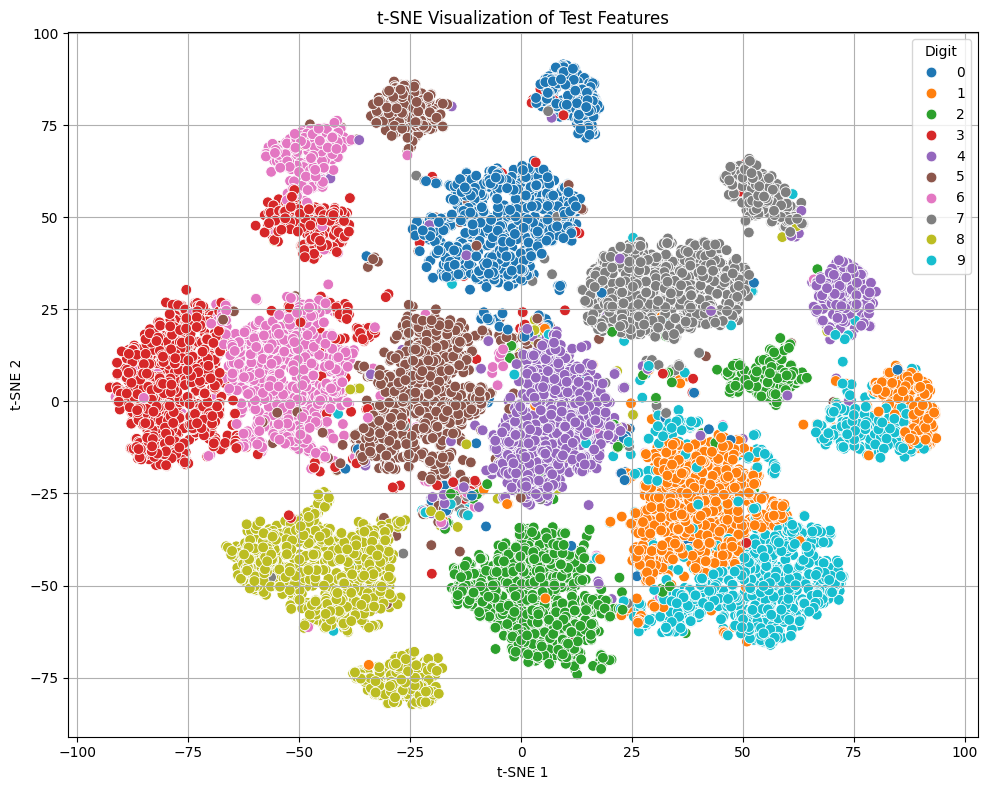

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE on training or validation feature space
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_test_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='tab10', legend='full', s=60)
plt.title("t-SNE Visualization of Test Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Digit")
plt.grid(True)
plt.tight_layout()
plt.show()


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


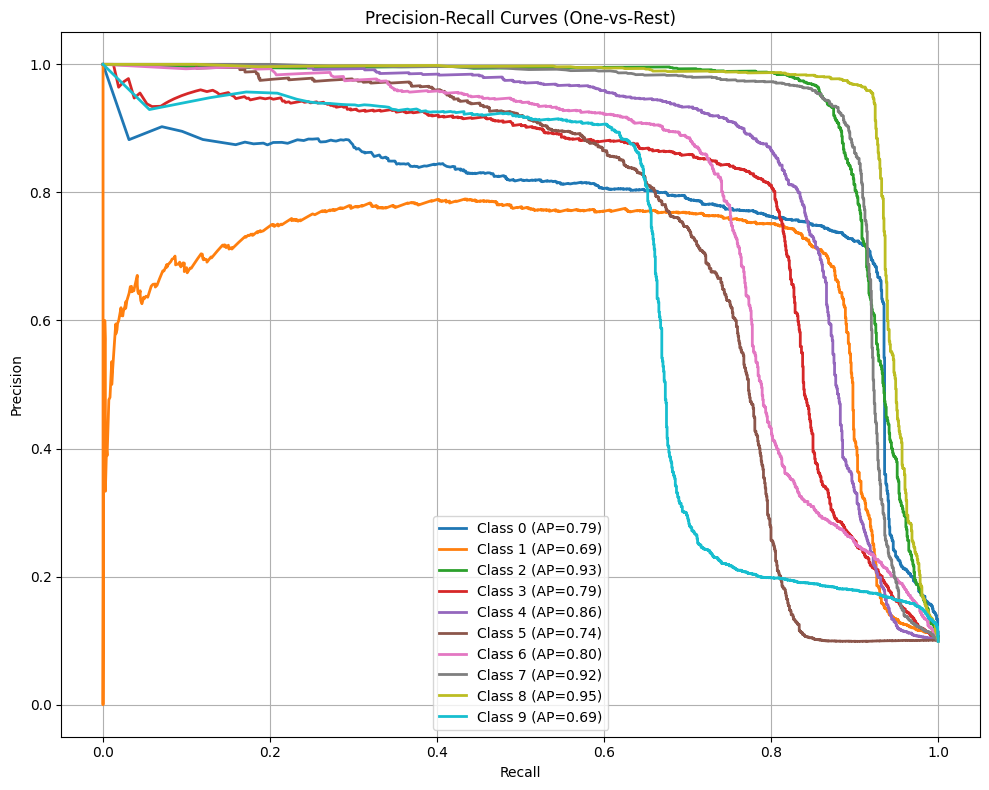

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get true labels and predicted probabilities
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # shape: (n_samples, n_classes)
y_scores = model.predict(X_test_combined)  # shape: (n_samples, n_classes)

# Compute PR curves
plt.figure(figsize=(10, 8))
for i in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP={ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


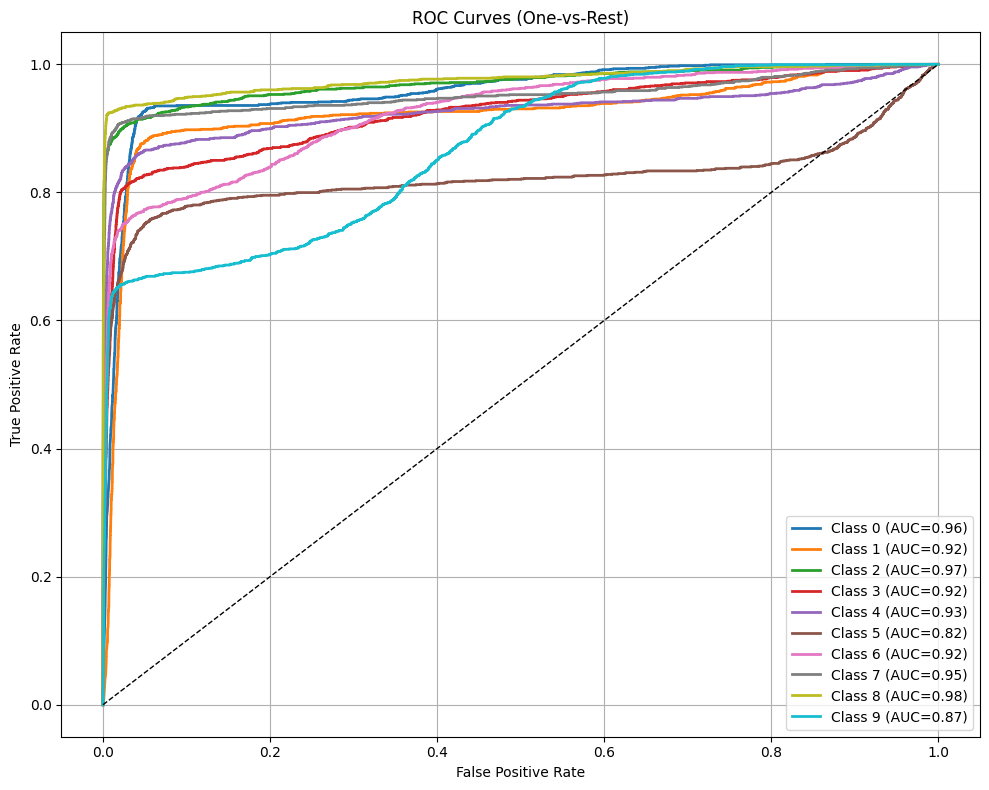

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
